<a href="https://colab.research.google.com/github/wasimshoman/NY_Taxi/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims at exploring machine learning abilities to predict values, classify and cluster groups for the NY taxi dataset.
We use different Machine learning technqiues such as regression analysis and Neural networks.

Data describtion:
The NY taxi data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

**Regression Analysis:**
Regression Analysis is a fundamental statistical technique used to understand the relationship between a dependent variable (the target you want to predict, Y) and one or more independent variables (the features you use to predict it, X).

The core goal of regression is to find a mathematical function that best fits the data, allowing you to estimate the value of Y when you know the values of X.

Key Characteristics:
Interpretability: Regression models, especially Linear Regression (like the code you shared), are highly interpretable. You get a direct equation (e.g., Y=m
1
​
 X
1
​
 +m
2
​
 X
2
​
 +n) where each coefficient (m) tells you exactly how much each feature (X) contributes to the predicted outcome (Y).

Assumptions: Regression relies on certain statistical assumptions about the data (like linearity, independence, and constant variance). If these assumptions are violated, the model's reliability decreases.



**Neural Networks**:
A Neural Network (NN) is a computational model inspired by the structure and function of the human brain. It's a key component of Deep Learning (DL) and modern Artificial Intelligence (AI).

A network is composed of layers of interconnected nodes (neurons), which take input, perform a simple mathematical operation, and pass the result to the next layer. This layered structure allows NNs to learn incredibly complex patterns and relationships in the data.

Key Characteristics:
Flexibility: NNs can model highly complex, non-linear relationships that simple regression cannot. They are "universal function approximators," meaning they can theoretically learn any function, given enough data and complexity.

Layers and Depth: A typical NN has an input layer, one or more hidden layers, and an output layer. Networks with many hidden layers are called Deep Neural Networks.

The "Black Box": NNs are generally less interpretable than regression. While you can look at the input and output weights, it's difficult to explain why the network made a specific prediction (though techniques like SHAP are helping).



# **Data preparation**

In [5]:
!pip install geopandas pandas numpy matplotlib seaborn contextily scikit-learn

In [6]:
!pip install tensorflow

In [7]:
import numpy as np
import pandas as pd
import warnings
from math import radians, sin, cos, sqrt, asin
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import minmax_scale, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
import tensorflow as tf
import os
from tensorflow.keras import layers
from statsmodels.graphics.gofplots import qqplot


In [8]:
#Silence non-critical warnings that often clutter the notebook output, making the results easier to read.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

In [9]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
set_seed()

In [10]:
# reading the file from my google drive or from the source in campus
#CSV_file= pd.read_csv('/content/NYC_trip.csv')
#drive.mount('/content/drive')

DRIVE_PATH = '/content/drive/MyDrive/Taxi_proj'
FILE_PATH = f"{DRIVE_PATH}/NYC_trip.csv"

DF_file= pd.read_csv(FILE_PATH)
init_rows, init_cols = DF_file.shape
print(f'the dimension of this dataset is {DF_file.shape}')

the dimension of this dataset is (1458644, 11)


In [11]:
DF_file.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


# Vislizing the location of points in the city

In [12]:
# creating a geodataframe to visuzlie the points
#combining longitude and latitude into Point objects
geometry = [Point(xy) for xy in zip(DF_file['pickup_longitude'], DF_file['pickup_latitude'])]
gdf = gpd.GeoDataFrame(DF_file.copy(), geometry=geometry, crs='EPSG:4326')

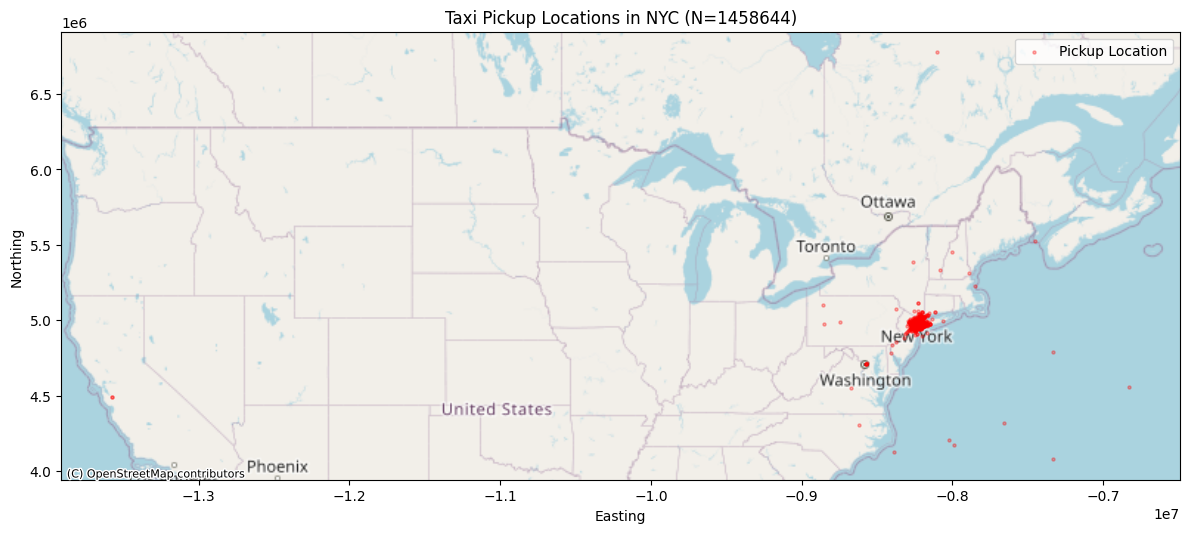

In [13]:


# convert to local projection
gdf_web_mercator = gdf.to_crs(epsg=3857)
# Plot the points .
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_web_mercator.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=5,
    alpha=0.3,
    label='Pickup Location'
)

# Add the basemap and retrieves the appropriate map tiles.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.legend()
plt.tight_layout()
plt.show()


**There is a problem with points being outside NY city**

In [14]:
# unrelated column to the purpose of the project
DF_file.drop(['id'], axis=1, inplace=True)

In [15]:
DF_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 111.3+ MB


In [16]:
# check null values
DF_file.isnull().sum()

,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0
trip_duration,0


In [17]:

# calculte the straight line distance in KM between the pickup and dropoff points
# the coordinates are represented in WGS 84
# the coordinate is geodiosic meaning that they are shown in decimal degrees
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points
    on the earth (specified in decimal degrees) using the Haversine formula.
    Returns the distance in kilometers.
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2

    # Earth's radius in kilometers
    R = 6371

    # Calculate the distance
    c = 2 * asin(sqrt(a))
    km = R * c
    return km

# We use np.vectorize for faster application across the entire DataFrame
# by converting the columns to NumPy arrays first.

try:
    # 1. Extract the coordinate arrays
    pickup_lon = DF_file['pickup_longitude'].values
    pickup_lat = DF_file['pickup_latitude'].values
    dropoff_lon = DF_file['dropoff_longitude'].values
    dropoff_lat = DF_file['dropoff_latitude'].values

    # 2. Vectorize the Haversine function for performance
    vectorized_haversine = np.vectorize(haversine)

    # 3. Apply the vectorized function and create the new column
    DF_file['Distance_KM'] = vectorized_haversine(
        pickup_lon, pickup_lat, dropoff_lon, dropoff_lat
    )

    print(DF_file['Distance_KM'].head())

except KeyError as e:
    print(f"Error: Missing column in DF_file. Please ensure your DataFrame has the column: {e}")
    print("The required columns are: 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'")
except Exception as e:
    print(f"An unexpected error occurred during calculation: {e}")


0    1.498521
1    1.805507
2    6.385098
3    1.485498
4    1.188588
Name: Distance_KM, dtype: float64


In [18]:
DF_file[DF_file['Distance_KM']<=0]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Distance_KM
246,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,0.0
291,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,0.0
407,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,0.0
702,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,0.0
1620,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1456399,2,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.978859,40.756721,-73.978859,40.756721,N,1284,0.0
1456627,2,2016-02-06 22:01:40,2016-02-06 22:03:47,1,-73.963554,40.768517,-73.963554,40.768517,N,127,0.0
1456989,2,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.984848,40.728222,-73.984848,40.728222,N,566,0.0
1457114,2,2016-04-09 20:34:21,2016-04-09 20:44:53,1,-73.965981,40.770988,-73.965981,40.770988,N,632,0.0


5897 rows with problems in their distances. origion = destination

In [19]:
DF_file['store_and_fwd_flag'].head(2)

,store_and_fwd_flag
0,N
1,N


convert the text N, Y values in store_and_fwd_flag to 0 and 1 respectively

In [20]:
DF_file['store_and_fwd_flag_V'] = DF_file['store_and_fwd_flag'].map({'N': 0, 'Y': 1})
DF_file['store_and_fwd_flag_V'].head()
DF_file.drop(['store_and_fwd_flag'], axis=1, inplace=True)

In [21]:
# check duplicated rows
DF_file.duplicated().sum()

np.int64(7)

***droping duplicates***

In [22]:
DF_file.drop_duplicates(inplace=True)

In [23]:
# identify the unique values for each column
unique_counts = DF_file.nunique()
print (unique_counts)

vendor_id                     2
pickup_datetime         1380222
dropoff_datetime        1380377
passenger_count              10
pickup_longitude          23047
pickup_latitude           45245
dropoff_longitude         33821
dropoff_latitude          62519
trip_duration              7417
Distance_KM             1452288
store_and_fwd_flag_V          2
dtype: int64


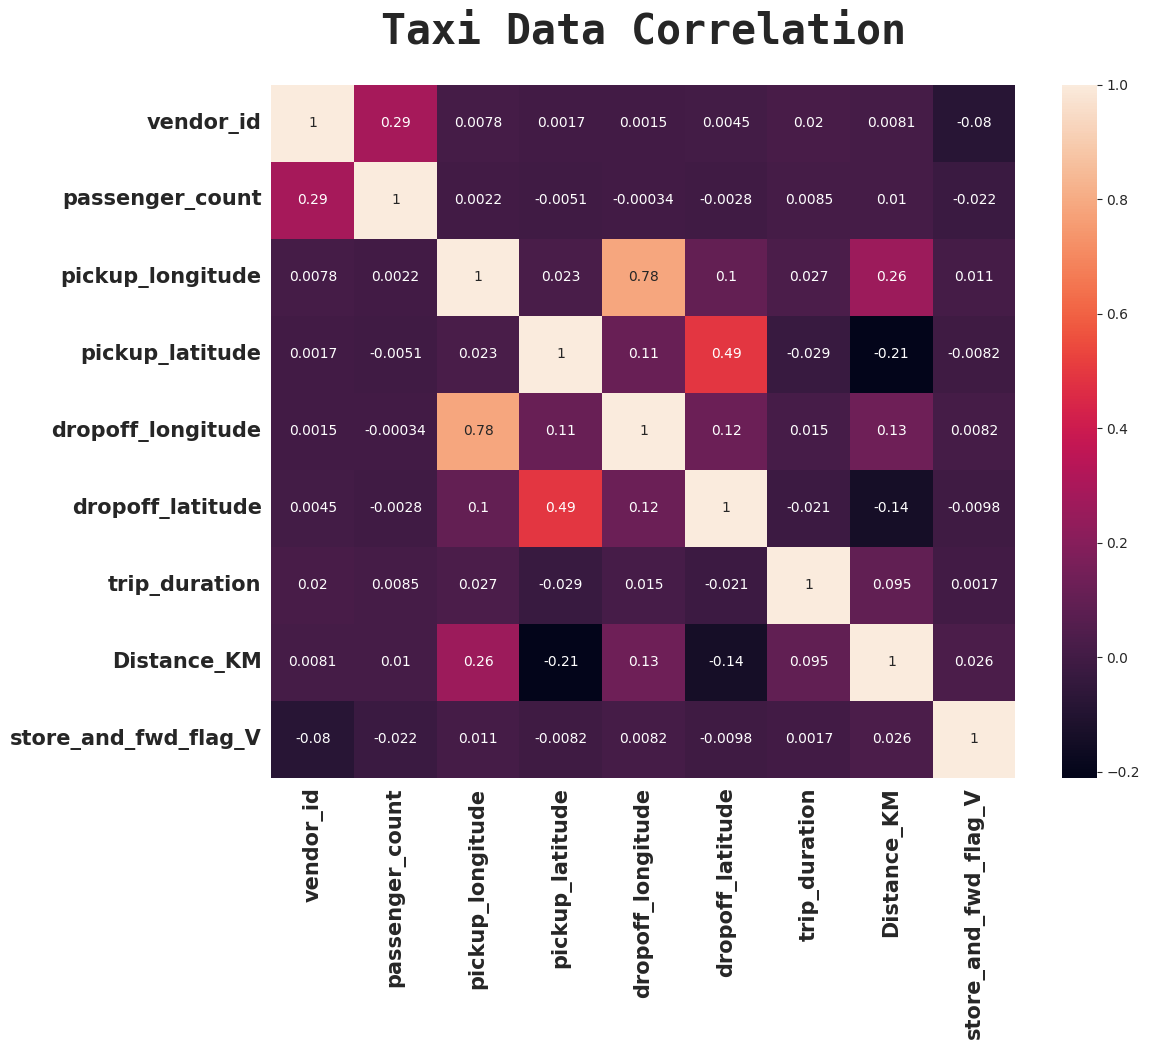

In [24]:
#check for correlation between numeric columns
numeric_columns = DF_file.select_dtypes(include=['float64', 'int64']).columns
sns.set_style("whitegrid") # set the seaborn style
plt.figure(figsize=(12, 9)) # figure the size
sns.heatmap(DF_file[numeric_columns].corr(), annot=True) # create a heatmap
plt.title("Taxi Data Correlation", weight="bold", fontsize=30, fontname="monospace", pad=30) # title
plt.xticks(weight="bold", fontsize=15) # x-ticks
plt.yticks(weight="bold", fontsize=15); # y-ticks

In [25]:
# Let's see the correlation clearly for the trip duration
(DF_file[numeric_columns].corr()["trip_duration"] # transform it into data corr
      .sort_values(ascending=False) # sort the values
      .to_frame() # change it into data frame
      .T) # transpose

,trip_duration,Distance_KM,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,store_and_fwd_flag_V,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.094791,0.026547,0.020296,0.014682,0.008452,0.001725,-0.020673,-0.029201


We have calculted calculated the Pearson correlation coefficients between various features and the target variable(trip_duration).The value ranges from −1 to +1:

+1.0: Perfect positive linear relationship (as one increases, the other increases).

0.0: No linear relationship.

−1.0: Perfect negative linear relationship (as one increases, the other decreases).



# **Feature engineering**

convert row data to valid formats for later application

identify weekends and weekdays




In [26]:
# --- 'pickup_datetime' is a proper datetime object ---
DF_file['pickup_datetime'] = pd.to_datetime(DF_file['pickup_datetime'])
# Create 'day_of_week' (Numerical) ---
# Monday=0, Tuesday=1, ..., Sunday=6.
DF_file['day_of_week'] = DF_file['pickup_datetime'].dt.dayofweek

# Create 'is_weekend' (Binary Flag) ---
# We define weekend as Saturday (5) or Sunday (6).
print("Creating 'is_weekend' (1=Weekend, 0=Weekday)...")
DF_file['is_weekend'] = DF_file['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


Creating 'is_weekend' (1=Weekend, 0=Weekday)...


In [27]:
DF_file.head(2)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,day_of_week,is_weekend
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,1.498521,0,0,0
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,1.805507,0,6,1


First, change datatime formats to seperate columns

In [28]:
object_columns =DF_file.select_dtypes(include=['object']).columns
for col in object_columns:
    print(f'{col}: {DF_file[col].nunique()}')
    print(f'{col}: {DF_file[col].unique()}', end='\n\n')

dropoff_datetime: 1380377
dropoff_datetime: ['2016-03-14 17:32:30' '2016-06-12 00:54:38' '2016-01-19 12:10:48' ...
 '2016-04-22 07:10:25' '2016-01-05 16:02:39' '2016-04-05 14:47:43']



In [29]:
# Extract start time and end time
DF_file['pickup_hour'] = pd.to_datetime(DF_file['pickup_datetime']).dt.hour
DF_file['pickup_day'] = pd.to_datetime(DF_file['pickup_datetime']).dt.day
DF_file['pickup_month'] = pd.to_datetime(DF_file['pickup_datetime']).dt.month
DF_file.drop('pickup_datetime', axis=1, inplace=True)

DF_file.drop('dropoff_datetime', axis=1, inplace=True)


In [30]:
DF_file.iloc[0]

,0
vendor_id,2.000000
passenger_count,1.000000
pickup_longitude,-73.982155
pickup_latitude,40.767937
dropoff_longitude,-73.964630
dropoff_latitude,40.765602
trip_duration,455.000000
Distance_KM,1.498521
store_and_fwd_flag_V,0.000000
day_of_week,0.000000


Drop unnecessary columns

checking correlation for relevant attribnutes

In [31]:
# Let's see the correlation clearly for the trip duration
(DF_file[numeric_columns].corr()["trip_duration"] # transform it into data corr
      .sort_values(ascending=False) # sort the values
      .to_frame() # change it into data frame
      .T) # transpose

,trip_duration,Distance_KM,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,store_and_fwd_flag_V,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.094791,0.026547,0.020296,0.014682,0.008452,0.001725,-0.020673,-0.029201


#visualization and handling errors/outliars

In [32]:

DF_file['passenger_count'].value_counts()

,count
passenger_count,
1,1033539
2,210315
5,78088
3,59895
6,48333
4,28402
0,60
7,3
9,1


drop rows with no passenger count attribute

In [33]:
DF_file = DF_file[DF_file['passenger_count'] != 0]

In [34]:
DF_file['store_and_fwd_flag_V'].value_counts()

,count
store_and_fwd_flag_V,
0,1450535
1,8042


In [35]:
DF_file['trip_duration'].value_counts()

,count
trip_duration,
368,1624
408,1584
348,1582
367,1581
358,1577
...,...
85002,1
81146,1
84575,1


In [36]:
DF_file[DF_file['trip_duration']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,day_of_week,is_weekend,pickup_hour,pickup_day,pickup_month


In [37]:
DF_file['Distance_KM'].value_counts()

,count
Distance_KM,
0.000000,5888
0.000424,101
0.000424,52
0.000424,48
0.000848,37
...,...
1.795028,1
8.261528,1
1.388063,1


In [38]:
DF_file[DF_file['Distance_KM']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,day_of_week,is_weekend,pickup_hour,pickup_day,pickup_month
246,2,1,-73.981819,40.768963,-73.981819,40.768963,227,0.0,0,0,0,18,29,2
291,2,2,-73.959068,40.775661,-73.959068,40.775661,1109,0.0,0,1,0,18,10,5
407,2,6,-73.808487,40.687336,-73.808487,40.687336,947,0.0,0,0,0,23,16,5
702,1,1,-73.786720,40.647041,-73.786720,40.647041,580,0.0,0,0,0,19,25,1
1620,1,1,-74.209854,40.816853,-74.209854,40.816853,27,0.0,0,2,0,22,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,2,1,-73.978859,40.756721,-73.978859,40.756721,1284,0.0,0,2,0,8,17,2
1456627,2,1,-73.963554,40.768517,-73.963554,40.768517,127,0.0,0,5,1,22,6,2
1456989,2,1,-73.984848,40.728222,-73.984848,40.728222,566,0.0,0,5,1,7,12,3
1457114,2,1,-73.965981,40.770988,-73.965981,40.770988,632,0.0,0,5,1,20,9,4


In [39]:
DF_file[DF_file['trip_duration']<=0]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,day_of_week,is_weekend,pickup_hour,pickup_day,pickup_month


In [40]:
DF_file = DF_file[DF_file['Distance_KM'] != 0]
DF_file.shape

(1452689, 14)

removed non zero distances

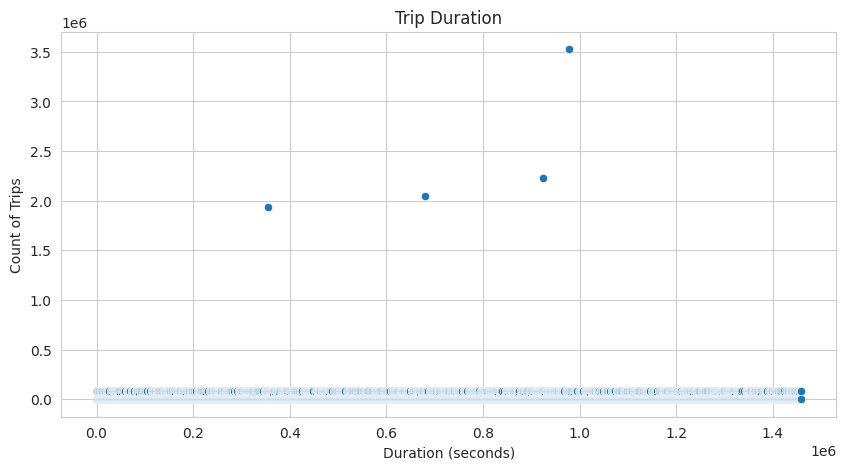

In [41]:
# Scatter for trip duration
plt.figure(figsize=(10, 5))
sns.scatterplot(data=DF_file['trip_duration'])
plt.title("Trip Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.show()
# results shows a signficant outliars that hinders the analysis which results in extremely high durations skew the visualization.


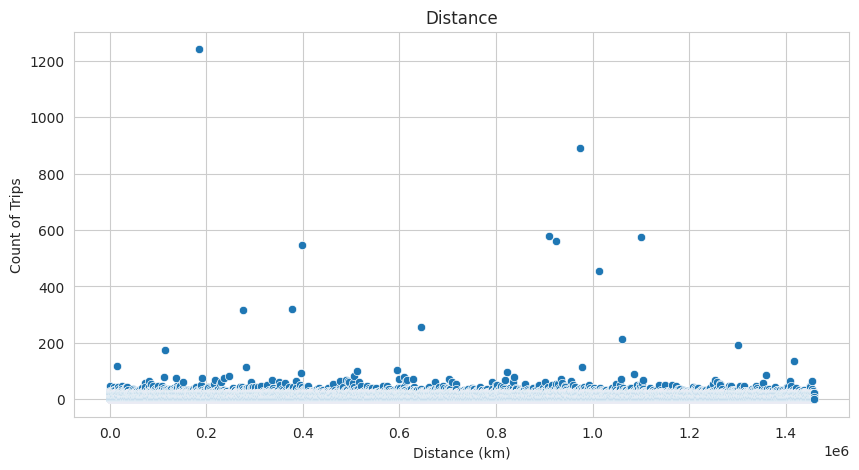

In [42]:
# Scatter for Distance
plt.figure(figsize=(10, 5))
sns.scatterplot(data=DF_file['Distance_KM'])
plt.title("Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Count of Trips")
plt.show()
# similar is shown for the distance

Cap duration: 3442.0 in seconds 
Cap distance: 24.795344966629102 in km
(1437125, 14)


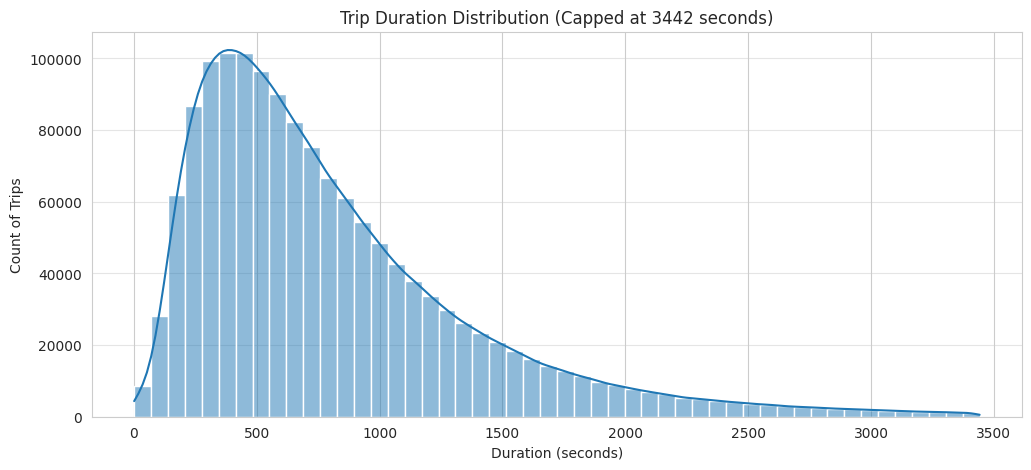

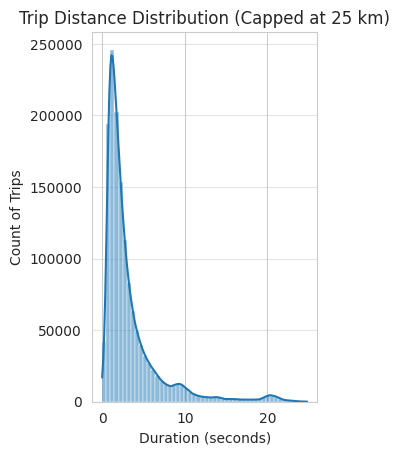

In [43]:
#avoid the outliars in both trip time and distance
# we select all datra with values below the 99th percentile for duration and 99.9th for distance


cap_duration = DF_file['trip_duration'].quantile(0.99)
cap_distance = DF_file['Distance_KM'].quantile(0.999)
print (f'Cap duration: {cap_duration} in seconds \nCap distance: {cap_distance} in km')

# Filter the data to remove extreme outliers for better visualization
df_filtered = DF_file[DF_file['trip_duration'] <= cap_duration]
# Filter the data to remove extreme outliers for better visualization
df_filtered = df_filtered[df_filtered['Distance_KM'] <= cap_distance]

print(df_filtered.shape)
'''


df_filtered = DF_file[DF_file['Distance_KM'] < 100]
df_filtered = df_filtered[df_filtered['trip_duration'] < 10000]
'''


# Use a Histogram to visualize the distribution for trip duration
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)
sns.histplot(data=df_filtered, x='trip_duration', bins=50, kde=True)
plt.title(f"Trip Duration Distribution (Capped at {cap_duration:.0f} seconds)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.grid(axis='y', alpha=0.5)
plt.show()



# Use a Histogram to visualize the distribution for trip ditsnace
plt.subplot(1, 2, 2)
sns.histplot(data=df_filtered, x='Distance_KM', bins=50, kde=True)
plt.title(f"Trip Distance Distribution (Capped at {cap_distance:.0f} km)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count of Trips")
plt.grid(axis='y', alpha=0.5)
plt.show()

In [44]:
#df_filtered

Remove data outside NY city (Outliers)

In [45]:

# Define NYC Bounding Box and Filter Outliers
NYC_BOUNDS = {
    'min_lat': 40.5, 'max_lat': 40.9,
    'min_lon': -74.25, 'max_lon': -73.70
}
# filter points only inside NY city
df_filtered = df_filtered[
(df_filtered['pickup_latitude'] >= NYC_BOUNDS['min_lat']) &
(df_filtered['pickup_latitude'] <= NYC_BOUNDS['max_lat']) &
(df_filtered['pickup_longitude'] >= NYC_BOUNDS['min_lon']) &
(df_filtered['pickup_longitude'] <= NYC_BOUNDS['max_lon'])
]



Only for viosualization

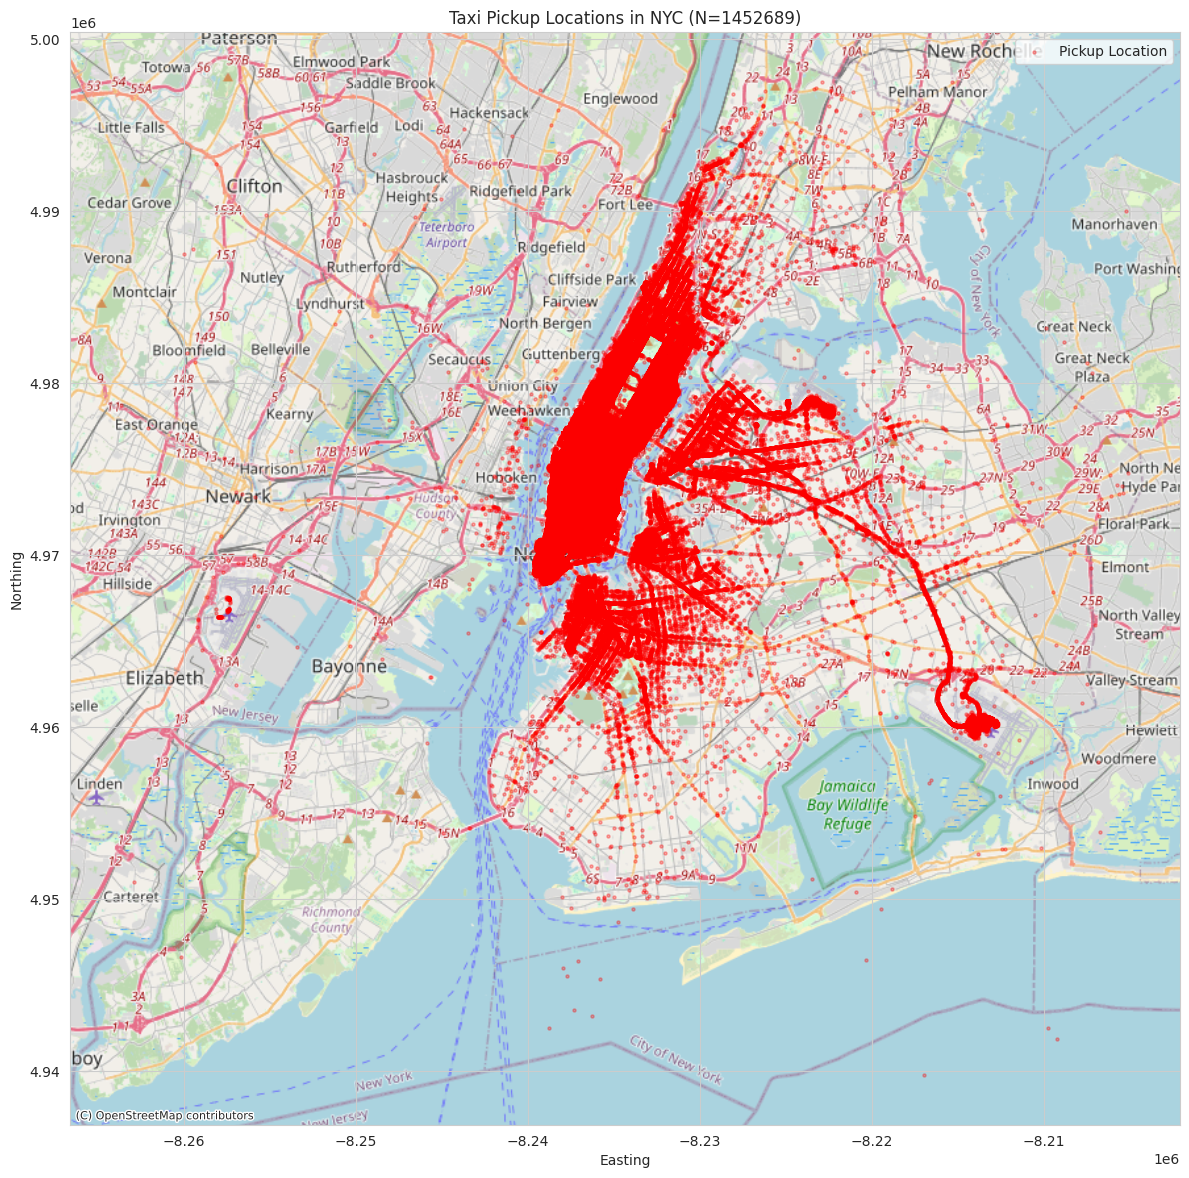

In [46]:
# update GeoDF
geometry = [Point(xy) for xy in zip(df_filtered['pickup_longitude'], df_filtered['pickup_latitude'])]
gdf = gpd.GeoDataFrame(df_filtered.copy(), geometry=geometry, crs='EPSG:4326')


# convert to local projection
gdf_web_mercator = gdf.to_crs(epsg=3857)
# Plot the points .
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_web_mercator.plot(
    ax=ax,
    marker='o',
    color='red',
    markersize=5,
    alpha=0.3,
    label='Pickup Location'
)

# Add the basemap and retrieves the appropriate map tiles.
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f"Taxi Pickup Locations in NYC (N={len(DF_file)})")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
#remove the unrequired attributres
'''
df_filtered.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)
df_filtered.head(2)
'''


"\ndf_filtered.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)\ndf_filtered.head(2)\n"

In [48]:
#removed rows
current_rows, current_cols = df_filtered.shape
print(f'Removed rows =  {init_rows- current_rows}\nwhich is about {round((init_rows- current_rows)/init_rows*100,2)}%')

Removed rows =  21700
which is about 1.49%


Normalizing data

In [49]:

scaler = minmax_scale(df_filtered, axis=0)
df_filtered_nor = pd.DataFrame(scaler, columns=df_filtered.columns)
df_filtered_nor.tail()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Distance_KM,store_and_fwd_flag_V,day_of_week,is_weekend,pickup_hour,pickup_day,pickup_month
1436939,1.0,0.428571,0.477670,0.608541,0.382933,0.511921,0.225806,0.049393,0.0,0.666667,0.0,0.565217,0.233333,0.6
1436940,0.0,0.000000,0.442078,0.613267,0.413690,0.622934,0.190061,0.243983,0.0,1.000000,1.0,0.304348,0.300000,0.0
1436941,1.0,0.000000,0.521475,0.667753,0.371090,0.447336,0.221738,0.315563,0.0,0.666667,0.0,0.260870,0.700000,0.6
1436942,0.0,0.000000,0.477902,0.617546,0.408157,0.545272,0.108108,0.044048,0.0,0.166667,0.0,0.652174,0.133333,0.0
1436943,0.0,0.000000,0.482726,0.700698,0.410426,0.611194,0.057251,0.045721,0.0,0.166667,0.0,0.608696,0.133333,0.6


# **Traing Data with linear regression **

In [50]:
x = df_filtered_nor.drop('trip_duration', axis=1)
y = df_filtered_nor['trip_duration']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1149555, 13), (287389, 13), (1149555,), (287389,))

In [51]:
pipline = {
    'Linear Regression': LinearRegression()
}
for name, model in pipline.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2_train = r2_score(y_train, model.predict(x_train))
    r2_test = r2_score(y_test, y_pred)
    # Extract coefficients (m)
    coefficients = model.coef_
    # Extract intercept (n)
    intercept = model.intercept_

    print(f'--- Model: {name} ---')
    print(f'MSE: {mse:.2f}')
    print(f'R2 train: {r2_train:.4f}')
    print(f'R2 test: {r2_test:.4f}')
    print(f'\nCoefficients (m):')
    for i, coeff in enumerate(coefficients):
        print(f'  {x_train.columns[i]}: {coeff:.4f}')
    print(f'Intercept (n): {intercept:.4f}')

    # Optional: Print the full equation
    equation = f"y = {intercept:.4f}"
    for i, coeff in enumerate(coefficients):
        equation += f" + ({coeff:.4f})*{x_train.columns[i]}"
    print(f'\nRegression Equation:\n{equation}')

--- Model: Linear Regression ---
MSE: 0.01
R2 train: 0.5895
R2 test: 0.5908

Coefficients (m):
  vendor_id: -0.0004
  passenger_count: 0.0072
  pickup_longitude: -0.1611
  pickup_latitude: 0.1387
  dropoff_longitude: -0.2493
  dropoff_latitude: -0.1508
  Distance_KM: 0.9367
  store_and_fwd_flag_V: 0.0078
  day_of_week: 0.0217
  is_weekend: -0.0389
  pickup_hour: 0.0262
  pickup_day: 0.0040
  pickup_month: 0.0227
Intercept (n): 0.2558

Regression Equation:
y = 0.2558 + (-0.0004)*vendor_id + (0.0072)*passenger_count + (-0.1611)*pickup_longitude + (0.1387)*pickup_latitude + (-0.2493)*dropoff_longitude + (-0.1508)*dropoff_latitude + (0.9367)*Distance_KM + (0.0078)*store_and_fwd_flag_V + (0.0217)*day_of_week + (-0.0389)*is_weekend + (0.0262)*pickup_hour + (0.0040)*pickup_day + (0.0227)*pickup_month


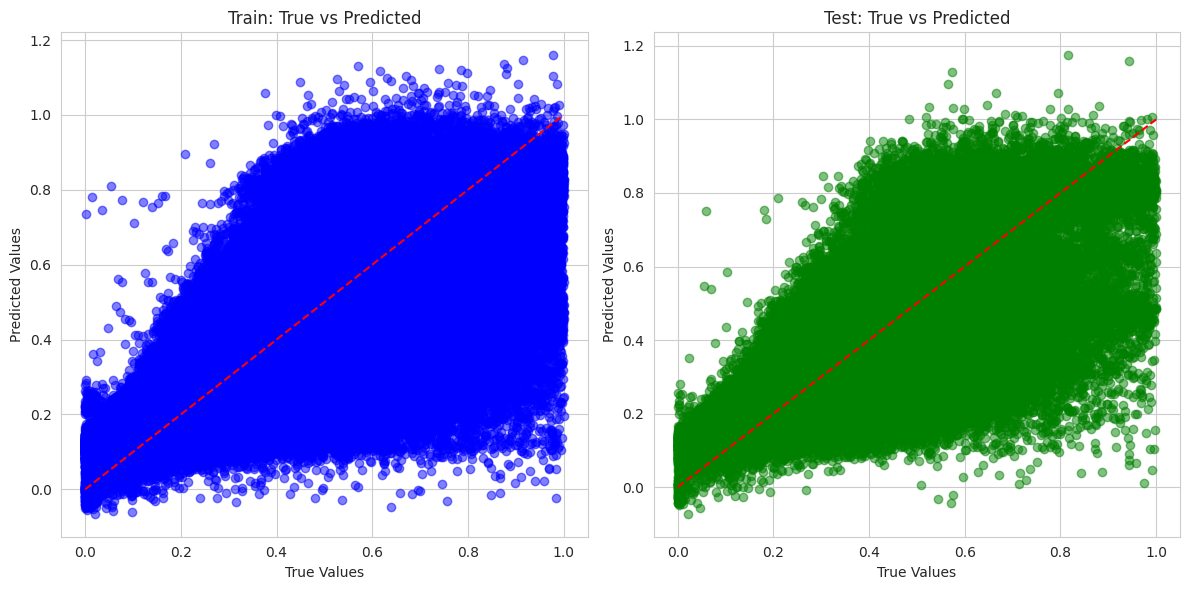

In [52]:
y_train_pred = pipline['Linear Regression'].predict(x_train)
y_test_pred = pipline['Linear Regression'].predict(x_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.title("Train: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Test: True vs Predicted")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

plt.tight_layout()
plt.show()

Due to very low correlation between the variables and trip duration the Linear Regression model shows a poor predictor of trip duration.
The model needs to capture the non-linearity relationship between the variables.

In [53]:
list_columns=df_filtered.columns.tolist()
try:
    list_columns.remove("store_and_fwd_flag_V")
except:
    pass
print(list_columns)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'Distance_KM', 'day_of_week', 'is_weekend', 'pickup_hour', 'pickup_day', 'pickup_month']


In [54]:

TARGET_COL= 'trip_duration'
# 1. Get ALL column names
list_columns = df_filtered.columns.tolist()

# 2. Define the categorical column list (Use the correct name)
categorical_col = ["store_and_fwd_flag_V"]

# 3. Define the numerical columns by EXCLUDING the target column and the categorical column
# The columns we pass to the transformer must only be the ones present in X.
numerical_col = [
    col for col in list_columns
    if col != TARGET_COL and col not in categorical_col
]


# --- 3. Create the Column Transformer ---
column_transformer = make_column_transformer(
    # Normalize numerical columns between 0 and 1
    (MinMaxScaler(), numerical_col),
    # One-hot encode categorical columns
    (OneHotEncoder(handle_unknown="ignore"), categorical_col)
)


# --- 4. Prepare Data and Split Sets ---
# Create X (features) & y (label)
X = df_filtered.drop(columns=[TARGET_COL])
y = df_filtered[TARGET_COL]

# Build our train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the columns transformer to our training data (Now this will succeed!)
column_transformer.fit(X_train)


# --- 5. Transform Data ---
X_train_normal = column_transformer.transform(X_train)
X_test_normal = column_transformer.transform(X_test)


# --- 6. Final preparation for Keras/TensorFlow ---
# Keras requires the label (y) to be a float, typically float32
y_train_tf = y_train.to_numpy().astype(np.float32)
y_test_tf = y_test.to_numpy().astype(np.float32)

print(f"Numerical Columns being scaled: {numerical_col}")
print(f"Categorical Column being encoded: {categorical_col}")
print(f"\nX_train shape after transformation: {X_train_normal.shape}")
print(f"y_train shape: {y_train_tf.shape}")
print("Data preprocessing complete and ready for model training!")

Numerical Columns being scaled: ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'Distance_KM', 'day_of_week', 'is_weekend', 'pickup_hour', 'pickup_day', 'pickup_month']
Categorical Column being encoded: ['store_and_fwd_flag_V']

X_train shape after transformation: (1149555, 14)
y_train shape: (1149555,)
Data preprocessing complete and ready for model training!


In [55]:
column_transformer

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['vendor_id', 'passenger_count',
                                  'pickup_longitude', 'pickup_latitude',
                                  'dropoff_longitude', 'dropoff_latitude',
                                  'Distance_KM', 'day_of_week', 'is_weekend',
                                  'pickup_hour', 'pickup_day',
                                  'pickup_month']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['store_and_fwd_flag_V'])])

In [56]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1149555, 287389, 1149555, 287389)

Modeling with TensorFlow¶
Creating a model - define the input and output layers, as well as hidden layers of a deep learning model.
Compile our model - define the loss function (in others words, the function which tells our model how wrong it is) and the optimizer (tells our model how to improve the patterns its learning) and evalution metrics (what we can use to interpret the performance of our model).
Fitting a model - letting the model try to find patterns betwwen
X
 &
y
 (features and labels).

In [57]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [58]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9523394069320229102
 xla_global_id: -1]

In [59]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [60]:
# This makes the training process reproducible.
set_seed()

# Create the model architecture using the Keras Sequential API.
# This stacks layers linearly.
small_model = tf.keras.Sequential([
    # Input Layer (and first Hidden Layer):
    # - 100 neurons.
    # - 'relu' activation function.
    # - 'input_shape=[13]': Must match the number of features (13) in your preprocessed data (X_train).
    layers.Dense(100, activation="relu", input_shape=[13], name="input_1"),

    # Second Hidden Layer:
    # - 10 neurons, designed to learn more complex patterns from the 100-neuron output.
    layers.Dense(10, activation="relu", name="input_2"),

    # Output Layer:
    # - 1 neuron: Required because we are predicting a single continuous value (trip_duration).
    # - No activation function (or a linear activation): This is standard for regression tasks.
    layers.Dense(1, name="output_layer")

], name="small_model")


# --- 2. Model Compilation ---

# Compile the model by defining the learning process parameters.
small_model.compile(
    # Loss Function: Mean Absolute Error (MAE).
    # This is the quantity the model attempts to minimize during training.
    loss="mae",

    # Optimizer: Adam (Adaptive Moment Estimation).
    # This is the algorithm that adjusts the model's weights to reduce the loss.
    optimizer=tf.keras.optimizers.Adam(),

    # Metrics: Mean Absolute Error (MAE).
    # This is the value that will be displayed and tracked during training.
    metrics=["mae"])


# --- 3. Model Fitting (Training) ---

# Train the model using the training data.
small_model_history = small_model.fit(
    # Training features and labels (X and y)
    X_train, y_train,

    # Validation Data: Used to monitor performance on unseen data after each epoch.
    validation_data=(X_test, y_test),

    # Epochs: The number of times the model will iterate over the entire training dataset.
    epochs=10)

Epoch 1/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 276.9594 - mae: 276.9594 - val_loss: 229.7237 - val_mae: 229.7237
Epoch 2/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 228.9643 - mae: 228.9643 - val_loss: 225.8630 - val_mae: 225.8630
Epoch 3/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 97s 3ms/step - loss: 223.3880 - mae: 223.3880 - val_loss: 220.6657 - val_mae: 220.6657
Epoch 4/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 146s 3ms/step - loss: 219.8552 - mae: 219.8552 - val_loss: 219.0088 - val_mae: 219.0088
Epoch 5/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 218.9392 - mae: 218.9392 - val_loss: 218.6536 - val_mae: 218.6536
Epoch 6/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 100s 3ms/step - loss: 218.3241 - mae: 218.3241 - val_loss: 218.1889 - val_mae: 218.1889
Epoch 7/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 112s 3ms/step - loss: 217.8539 - mae: 217.8539 - val_loss: 218.4529 - val_mae: 218.4529
Epoch 8/10
35924/35924 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step - loss: 217.4117 - ma

In [61]:
small_model.summary() # let's see its layer

Model: "small_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (Dense)                 │ (None, 100)            │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,265 (28.38 KB)

 Trainable params: 2,421 (9.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,844 (18.93 KB)

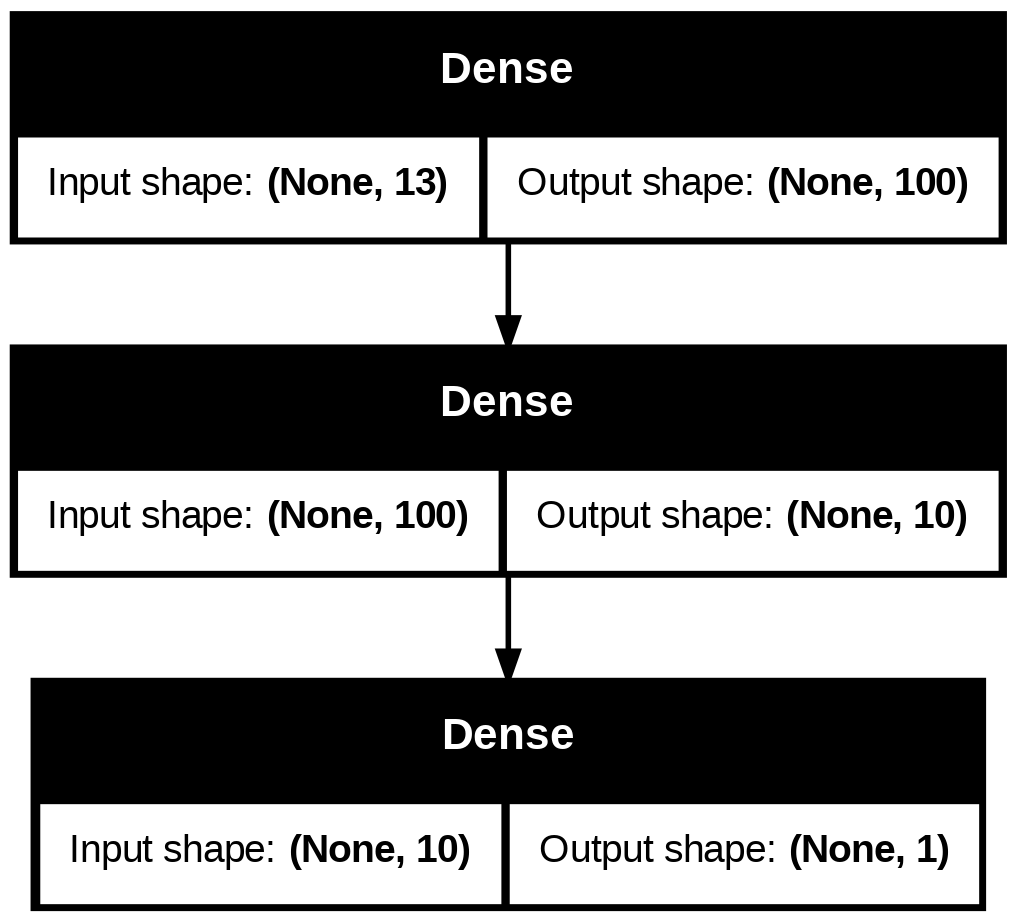

In [62]:
tf.keras.utils.plot_model(small_model, show_shapes=True) # let's see its architecture
